## Implementing Convolutional Layers with Keras

In [ ]:
# Let's load and preprocess a couple of sample images using Sklearn
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=258, width=258)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

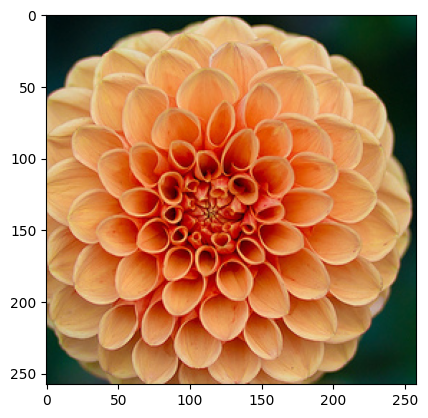

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(images[1])

In [ ]:
# Now let's create a 2D conv layer and feed the images
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7) # kernel_size=7 means (7, 7) | padding="valid" by default which means no zero-padding
fmaps = conv_layer(images)

In [ ]:
fmaps.shape

TensorShape([2, 252, 252, 32])

In [ ]:
# Now let's set padding="same", output feature maps end up with the smae size as the inputs
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,
                                    padding="same")

fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 258, 258, 32])

In [ ]:
# You can get weights as well
kernels, biases = conv_layer.get_weights()
kernels.shape, biases.shape

((7, 7, 3, 32), (32,))

In [ ]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

## Implementing Pooling Layers with Keras

In [ ]:
# Create a MaxPooling2D layer
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [ ]:
# Create an AveragePooling2D layer (loses less information, computes the mean)
avg_pool = tf.keras.layers.AveragePooling2D(pool_size=2)

In [ ]:
# Let's implement a depthwise max pooling layer
class DepthPool(tf.keras.layers.Layer):
  def __init__(self, pool_size=2, **kwargs):
    super().__init__(**kwargs)
    self.pool_size = pool_size

  def call(self, inputs):
    shape = tf.shape(inputs)
    groups = shape[-1] // self.pool_size # number of channel groups
    new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
    return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

In [ ]:
# Create GlobalAvgPool2D (very information destructive, useful just before the output layer)
global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()

In [ ]:
global_avg_pool(images) # mean intencity of red, green, and blue

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.60654515, 0.57655704, 0.5618675 ],
       [0.69630605, 0.44583344, 0.25930038]], dtype=float32)>

In [ ]:
# Implement basic CNN
from functools import partial
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")

cnn_model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[64, 64, 3]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=40, activation="softmax")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
optimizer = tf.keras.optimizers.SGD(momentum=0.1, learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy()

cnn_model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

In [ ]:
# Test it out on custom dataset
import numpy as np
import tensorflow as tf

arrays = np.load('photos_tensor500.npy')
photos_tensor = tf.convert_to_tensor(arrays)

In [ ]:
import pandas as pd
data = pd.read_csv("celeb.csv")[:500]

data_no_id = data.drop("ID", axis=1)
data_copy = data_no_id.copy()

data_copy = tf.convert_to_tensor(data_copy)

In [ ]:
# Define sets (train, val, test)
train_split, val_split, test_split = int(len(photos_tensor)*0.7), int(len(photos_tensor)*0.2), int(len(photos_tensor)*0.1)


X_train, y_train = photos_tensor[:train_split], data_copy[:train_split]
X_val, y_val = photos_tensor[train_split:train_split+val_split], data_copy[train_split:train_split+val_split]
X_test, y_test = photos_tensor[train_split+val_split:], data_copy[train_split+val_split:]

In [ ]:
# Define callbacks and fit the model
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16,
                epochs=20, callbacks=[early_stop])

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.0134 - loss: 46.1882 - val_accuracy: 0.0000e+00 - val_loss: 0.6999
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.0019 - loss: 0.7056 - val_accuracy: 0.0000e+00 - val_loss: 0.6961
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.0000e+00 - loss: 0.6967 - val_accuracy: 0.0000e+00 - val_loss: 0.6948
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 39s 989ms/step - accuracy: 0.0045 - loss: 0.6931 - val_accuracy: 0.0000e+00 - val_loss: 0.6936
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.0025 - loss: 0.6956 - val_accuracy: 0.0000e+00 - val_loss: 0.6929
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.0000e+00 - loss: 0.6929 - val_accuracy: 0.0000e+00 - val_loss: 0.6929
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 2.4845e-04 - loss: 0.6930 - val_accuracy: 0.0000e+00 - val_loss: 0.6929
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 991ms/step - accuracy: 0.0000e+0

In [ ]:
cnn_model.predict(X_test)[0], y_test

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step


(array([0.02493241, 0.02507427, 0.02509764, 0.02498171, 0.02501849,
        0.02497022, 0.02505303, 0.02493609, 0.02499208, 0.02508814,
        0.0249295 , 0.02499283, 0.02499555, 0.02490508, 0.02498317,
        0.02489027, 0.02497262, 0.02491176, 0.02499642, 0.02503337,
        0.02506754, 0.02511198, 0.02493837, 0.02501705, 0.02527553,
        0.02491838, 0.02487677, 0.02497842, 0.02497324, 0.02491699,
        0.02492793, 0.02513154, 0.02504844, 0.02497214, 0.02495667,
        0.02495203, 0.02503859, 0.02497426, 0.02484757, 0.02532198],
       dtype=float32),
 <tf.Tensor: shape=(50, 40), dtype=bool, numpy=
 array([[False, False,  True, ..., False, False,  True],
        [False, False, False, ..., False,  True, False],
        [False, False, False, ..., False, False,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ...,  True, False,  True],
        [False, False, False, ..., False, False,  True]])>)

## LeNet-5 CNN

In [ ]:
# Load digits MNIST
import tensorflow as tf
import tensorflow_datasets as tfds

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


(<matplotlib.image.AxesImage at 0x79674d86f250>, (28, 28))

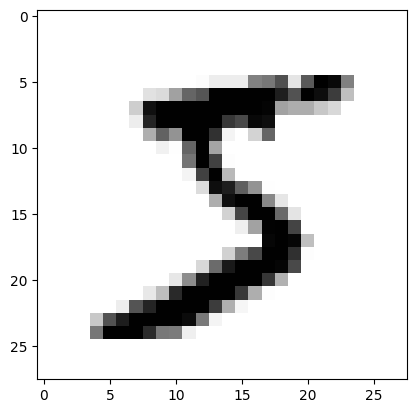

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(X_train[0], cmap="binary"), X_train[0].shape

## LeNet-5

In [ ]:
# LeNet-5
from functools import partial
conv = partial(tf.keras.layers.Conv2D, filters=6, activation="relu", kernel_size=5)

lenet_5 = tf.keras.Sequential([
    tf.keras.layers.Input((28, 28, 1)),
    conv(),
    tf.keras.layers.AveragePooling2D(pool_size=2, strides=2),
    conv(filters=16),
    tf.keras.layers.AveragePooling2D(pool_size=4, strides=1),
    conv(filters=120, kernel_size=5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(84, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
], name="LeNet-5")

In [ ]:
lenet_5.summary()

Model: "LeNet-5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_102 (Conv2D)             │ (None, 24, 24, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_73            │ (None, 12, 12, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 8, 8, 16)       │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_74            │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 1, 1, 120)      │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lenet_5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"])

In [ ]:
X_val, y_val = X_train[:10000], y_train[:10000]
X_train, y_train = X_train[10000:], y_train[10000:]

In [ ]:
es = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

lenet_5.fit(X_train, y_train, batch_size=64, validation_data=(X_val, y_val), callbacks=[es], epochs=3)

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.6690 - loss: 1.7624 - val_accuracy: 0.9255 - val_loss: 0.2278
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9549 - loss: 0.1522 - val_accuracy: 0.9620 - val_loss: 0.1132
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.9670 - loss: 0.1053 - val_accuracy: 0.9735 - val_loss: 0.0844


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Text(0.5, 1.0, 'Predicted as: 0')

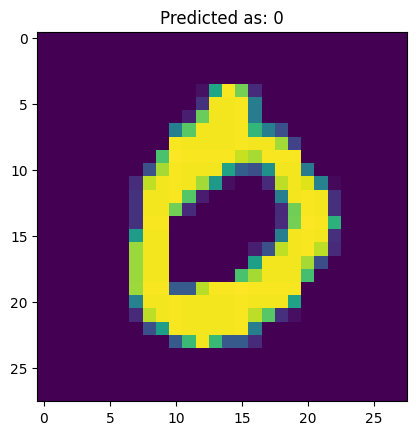

In [ ]:
sample_idx = 3

plt.imshow(X_test[sample_idx])
plt.title(f"Predicted as: {int(np.argmax(lenet_5.predict(np.expand_dims(X_test[sample_idx], 0))))}")

## AlexNet

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar100.load_data()

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
alex_net = tf.keras.Sequential([
    tf.keras.layers.Input((32, 32, 3)),
    tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4, activation="relu"),
    tf.keras.layers.MaxPooling2D(strides=2),
    tf.keras.layers.Conv2D(filters=256, kernel_size=5, strides=1, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(strides=1),
    tf.keras.layers.Conv2D(filters=384, kernel_size=3, strides=1, padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=384, kernel_size=3, strides=1, padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(strides=1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation="softmax")
], name="AlexNet")

In [ ]:
alex_net.summary()

Model: "AlexNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_135 (Conv2D)             │ (None, 6, 6, 96)       │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 3, 3, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_136 (Conv2D)             │ (None, 3, 3, 256)      │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_137 (Conv2D)             │ (None, 2, 2, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_138 (Conv2D)             │ (None, 2, 2, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_139 (Conv2D)             │ (None, 2, 2, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 100)            │       409,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,990,884 (83.89 MB)

 Trainable params: 21,990,884 (83.89 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_val, y_val = X_train[:10000], y_train[:10000]
X_train, y_train = X_train[10000:], y_train[10000:]

In [ ]:
alex_net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"])

In [ ]:
alex_net.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, callbacks=[es], epochs=2)

Epoch 1/2
469/469 ━━━━━━━━━━━━━━━━━━━━ 616s 1s/step - accuracy: 0.0095 - loss: 1994.1630 - val_accuracy: 0.0096 - val_loss: 4.6095
Epoch 2/2
469/469 ━━━━━━━━━━━━━━━━━━━━ 641s 1s/step - accuracy: 0.0103 - loss: 4.6075 - val_accuracy: 0.0097 - val_loss: 4.6073


In [ ]:
# Local Response Normalization used in ZF Net (a variant of AlexNet)
# tf.nn.local_response_normalization(bias=2, alpha=0.0001, beta=0.75)

## GoogLeNet

In [ ]:
# Inception Module Implementation (used in GoogLeNet; "conv layer on steroids")
class InceptionModule(tf.keras.layers.Layer):
  def __init__(self, cnn_1_2_, cnn_1_3_, cnn_2_1_, cnn_2_2_, cnn_2_3_, cnn_2_4_, **kwargs):
    super(InceptionModule, self).__init__(**kwargs)
    # First layer
    self.cnn_1_2 = tf.keras.layers.Conv2D(cnn_1_2_, kernel_size=1, strides=1, padding="same", activation="relu")
    self.cnn_1_3 = tf.keras.layers.Conv2D(cnn_1_3_, kernel_size=1, strides=1, padding="same", activation="relu")
    self.maxpool_1_4 = tf.keras.layers.MaxPool2D(pool_size=3, strides=1, padding="same")

    # Second layer
    self.cnn_2_1 = tf.keras.layers.Conv2D(cnn_2_1_, kernel_size=1, strides=1, padding="same", activation="relu")
    self.cnn_2_2 = tf.keras.layers.Conv2D(cnn_2_2_, kernel_size=3, strides=1, padding="same", activation="relu")
    self.cnn_2_3 = tf.keras.layers.Conv2D(cnn_2_3_, kernel_size=5, strides=1, padding="same", activation="relu")
    self.cnn_2_4 = tf.keras.layers.Conv2D(cnn_2_4_, kernel_size=1, strides=1, padding="same", activation="relu")

  def call(self, input_):
    x1 = self.cnn_1_2(input_)
    x2 = self.cnn_1_3(input_)
    x3 = self.maxpool_1_4(input_)

    p1 = self.cnn_2_1(input_)
    p2 = self.cnn_2_2(x1)
    p3 = self.cnn_2_3(x2)
    p4 = self.cnn_2_4(x3)

    return tf.keras.layers.concatenate([p1, p2, p3, p4], axis=-1)

In [ ]:
# Implement GoogLeNet
from functools import partial
conv_layer = partial(tf.keras.layers.Conv2D, padding="same", activation="relu")

# ------------
input_ = tf.keras.layers.Input([224, 224, 3])
cnn_1 = conv_layer(64, 7, 2)(input_)
maxpool_1 = tf.keras.layers.MaxPool2D(3, 2, padding="same")(cnn_1)
lrn_1 = tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, bias=2, alpha=0.0001, beta=0.75))(maxpool_1)
# ------------
cnn_2 = conv_layer(64, 1, 1)(lrn_1)
cnn_3 = conv_layer(192, 3, 1)(cnn_2)
lrn_2 = tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, bias=2, alpha=0.0001, beta=0.75))(cnn_3)
maxpool_2 = tf.keras.layers.MaxPool2D(3, strides=2, padding="same")(lrn_2)
# ------------
inception_module_1 = InceptionModule(64, 128, 32, 32, 96, 12)(maxpool_2)
inception_module_2 = InceptionModule(128, 192, 96, 64, 128, 32)(inception_module_1)
maxpool_3 = tf.keras.layers.MaxPool2D(3, 2, padding="same")(inception_module_2)
inception_module_3 = InceptionModule(192, 208, 48, 64, 96, 16)(maxpool_3)
inception_module_4 = InceptionModule(160, 224, 64, 64, 112, 24)(inception_module_3)
inception_module_5 = InceptionModule(128, 256, 64, 64, 128, 24)(inception_module_4)
inception_module_6 = InceptionModule(112, 288, 64, 64, 144, 32)(inception_module_5)
# ------------
inception_module_7 = InceptionModule(256, 320, 128, 128, 160, 32)(inception_module_6)
maxpool_4 = tf.keras.layers.MaxPool2D(3, 2, padding="same")(inception_module_7)
inception_module_8 = InceptionModule(256, 320, 128, 128, 160, 32)(maxpool_4)
inception_module_9 = InceptionModule(384, 384, 128, 128, 192, 48)(inception_module_8)
glob_avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inception_module_9)
dropout = tf.keras.layers.Dropout(0.4)(glob_avg_pool)
flatten_ = tf.keras.layers.Flatten()(dropout)
output = tf.keras.layers.Dense(1000, activation="softmax")(flatten_)

In [ ]:
googlenet = tf.keras.Model(inputs=input_, outputs=output)
googlenet.save("GoogLeNet.keras")

In [ ]:
googlenet.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_245 (Conv2D)             │ (None, 112, 112, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_20 (Lambda)              │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_246 (Conv2D)             │ (None, 56, 56, 64)     │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_247 (Conv2D)             │ (None, 56, 56, 192)    │       110,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_21 (Lambda)              │ (None, 56, 56, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 28, 28, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_module_29             │ (None, 28, 28, 172)    │       371,308 │
│ (InceptionModule)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_module_30             │ (None, 28, 28, 320)    │       765,824 │
│ (InceptionModule)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 14, 14, 320)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_module_31             │ (None, 14, 14, 224)    │       758,896 │
│ (InceptionModule)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_module_32             │ (None, 14, 14, 264)    │       825,736 │
│ (InceptionModule)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_module_33             │ (None, 14, 14, 280)    │     1,018,200 │
│ (InceptionModule)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_module_34             │ (None, 14, 14, 304)    │     1,240,896 │
│ (InceptionModule)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_module_35             │ (None, 14, 14, 448)    │     1,799,680 │
│ (InceptionModule)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (None, 7, 7, 448)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_module_36             │ (None, 7, 7, 448)      │     1,905,664 │
│ (InceptionModule)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_module_37             │ (None, 7, 7, 496)      │     2,709,744 │
│ (InceptionModule)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 496)            │             0 │
│ (GlobalAveragePooling2D)        │                        │             

 Total params: 12,017,364 (45.84 MB)

 Trainable params: 12,017,364 (45.84 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile GoogLeNet
googlenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"])

## Skip Connection & Residual Unit & ResNet

In [ ]:
# Implement Skip Connection
input_ = tf.keras.layers.Input([28, 28, 1])
conv_layer_1 = tf.keras.layers.Conv2D(64, 3, 1, padding="same", activation="relu")(input_)
conv_layer_2 = tf.keras.layers.Conv2D(64, 3, 1, padding="same", activation="relu")(conv_layer_1)
concat = tf.keras.layers.concatenate([input_, conv_layer_2], axis=-1)
output = tf.keras.layers.Dense(10, activation="softmax")(concat)

skip_connection_model = tf.keras.Model(inputs=input_, outputs=output)

In [ ]:
skip_connection_model.save("skip_connection_model.keras")

In [ ]:
# Implement Residual Unit
input_ = tf.keras.layers.Input([28, 28, 1])
conv_layer_1 = tf.keras.layers.Conv2D(64, 3, 1, padding="same", activation="relu")(input_)
batch_norm_1 = tf.keras.layers.BatchNormalization()(conv_layer_1)
conv_layer_2 = tf.keras.layers.Conv2D(64, 3, 1, padding="same")(batch_norm_1)
batch_norm_2 = tf.keras.layers.BatchNormalization()(conv_layer_2)
concat = tf.keras.layers.concatenate([input_, batch_norm_2], axis=-1)
relu = tf.keras.layers.ReLU()(concat)
output = tf.keras.layers.Dense(10, activation="softmax")(relu)

residual_unit = tf.keras.Model(inputs=input_, outputs=output)


In [ ]:
# Implement ResidualUnit class
class ResidualUnit(tf.keras.layers.Layer):
  def __init__(self, conv1, conv2, variant2=False, **kwargs):
    super(ResidualUnit, self).__init__(**kwargs)
    self.variant2 = variant2
    if variant2:
      self.conv_layer_1 = tf.keras.layers.Conv2D(filters=conv1, kernel_size=3, strides=2, activation="relu", padding="same")
    else:
      self.conv_layer_1 = tf.keras.layers.Conv2D(filters=conv1, kernel_size=3, strides=1, activation="relu", padding="same")
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()
    self.conv_layer_2 = tf.keras.layers.Conv2D(filters=conv2, kernel_size=3, strides=1, padding="same")
    self.batch_norm_2 = tf.keras.layers.BatchNormalization()
    self.relu = tf.keras.layers.ReLU()

  def call(self, input_):
    x1 = self.conv_layer_1(input_)
    if self.variant2:
      aux = tf.keras.layers.Conv2D(128, 1, 2, padding="same")(input_)
      bn = tf.keras.layers.BatchNormalization()(aux)
    x2 = self.batch_norm_1(x1)
    x3 = self.conv_layer_2(x2)
    x4 = self.batch_norm_2(x3)
    if self.variant2:
      concat = tf.keras.layers.concatenate([bn, x4], axis=-1)
    else:
      concat = tf.keras.layers.concatenate([input_, x4], axis=-1)

    return self.relu(concat)

In [ ]:
# Impelement ResNet
input_ = tf.keras.layers.Input([128, 128, 3])
conv_1 = tf.keras.layers.Conv2D(64, 7, 2, padding="same", activation="relu")(input_)
maxpool_1 = tf.keras.layers.MaxPool2D(3, 2, padding="same")(conv_1)
ru_1 = ResidualUnit(conv1=64, conv2=64)(maxpool_1)
ru_2 = ResidualUnit(conv1=64, conv2=64)(ru_1)
ru_3 = ResidualUnit(conv1=128, conv2=128, variant2=True)(ru_2)
ru_4 = ResidualUnit(conv1=128, conv2=128)(ru_3)
glob_avg_pool = tf.keras.layers.GlobalAveragePooling2D()(ru_4)
flatten_ = tf.keras.layers.Flatten()(glob_avg_pool)
output = tf.keras.layers.Dense(1000, activation="softmax")(flatten_)

res_net = tf.keras.Model(inputs=input_, outputs=output)

In [ ]:
res_net.save("res_net.keras")

### Separable Convolutional layers & DepthWise Convolutional layers

In [ ]:
spearable_conv2d = tf.keras.layers.SeparableConv2D(54, 3, 1, activation="relu")
depthwise_conv2d = tf.keras.layers.DepthwiseConv2D(3, 1, padding="same")

## SENet

In [ ]:
# SE-Inception module implementation
class SEInceptionModule(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(SEInceptionModule, self).__init__(**kwargs)
    self.inception_module = InceptionModule(128, 128, 64, 64, 32, 32) # filters amount as arguments
    self.glob_avg_pool = tf.keras.layers.GlobalAveragePooling2D()
    self.dense_1 = tf.keras.layers.Dense(32, activation="relu")
    self.dense_2 = tf.keras.layers.Dense(192, activation="sigmoid")

  def call(self, input_):
    x1 = self.inception_module(input_)

    se_1 = self.glob_avg_pool(x1)
    se_2 = self.dense_1(se_1)
    se_3 = self.dense_2(se_2)
    se_3 = tf.reshape(se_3, [-1, 1, 1, 192]) # broadcasting for multiplication

    multiplication = x1 * se_3

    return multiplication

In [ ]:
dummy_input = tf.random.normal([1, 64, 64, 3])  # Example input shape
se_inception = SEInceptionModule()
output = se_inception(dummy_input)
print(output.shape)

(1, 64, 64, 192)


In [ ]:
# SE-ResNet unit module implementation
class SEResNetUnit(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(SEResNetUnit, self).__init__(**kwargs)
    self.inception_module = InceptionModule(128, 128, 64, 64, 32, 32) # filters amount as arguments
    self.glob_avg_pool = tf.keras.layers.GlobalAveragePooling2D()
    self.dense_1 = tf.keras.layers.Dense(32, activation="relu")
    self.dense_2 = tf.keras.layers.Dense(192, activation="sigmoid")

  def call(self, input_):
    x1 = self.inception_module(input_)

    se_1 = self.glob_avg_pool(x1)
    se_2 = self.dense_1(se_1)
    se_3 = self.dense_2(se_2)
    se_3 = tf.reshape(se_3, [-1, 1, 1, 192]) # broadcasting for multiplication

    multiplication = x1 * se_3

    concat = tf.keras.layers.Concatenate([input_, multiplication])

    return concat

In [ ]:
dummy_input = tf.random.normal([1, 64, 64, 3])  # Example input shape
se_resnet = SEResNetUnit()
output = se_inception(dummy_input)
print(output.shape)

(1, 64, 64, 192)


# Implementing ResNet-34 CNN

In [ ]:
# Implement Residual Unit
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
  def __init__(self, filters, strides=1, activation="relu", **kwargs):
    super().__init__(**kwargs)
    self.activation = tf.keras.activations.get(activation)
    self.main_layers = [
        DefaultConv2D(filters, strides=strides),
        tf.keras.layers.BatchNormalization(),
        self.activation,
        DefaultConv2D(filters),
        tf.keras.layers.BatchNormalization()
    ]
    self.skip_layers = []
    if strides > 1:
      self.skip_layers = [
          DefaultConv2D(filters, kernel_size=1, strides=strides)
      ]

  def call(self, inputs):
    X = inputs
    for layer in self.main_layers:
      X = layer(X)
    skip_X = inputs
    for layer in self.skip_layers:
      skip_X = layer(skip_X)

    return self.activation(X + skip_X)

In [ ]:
# Implement ResNet-34
res_net_34 = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  strides = 1 if filters == prev_filters else 2
  res_net_34.add(ResidualUnit(filters, strides=strides))
  prev_filters = filters

res_net_34.add(tf.keras.layers.GlobalAvgPool2D())
res_net_34.add(tf.keras.layers.Flatten())
res_net_34.add(tf.keras.layers.Dense(10, activation="softmax"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
res_net_34.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 112, 112, 64)   │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_4 (ResidualUnit)  │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_5 (ResidualUnit)  │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_6 (ResidualUnit)  │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_7 (ResidualUnit)  │ (None, 28, 28, 128)    │       230,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_8 (ResidualUnit)  │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_9 (ResidualUnit)  │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_10 (ResidualUnit) │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_11 (ResidualUnit) │ (None, 14, 14, 256)    │       919,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_12 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_13 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_14 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_15 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_16 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_17 (ResidualUnit) │ (None, 7, 7, 512)      │     3,674,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_18 (ResidualUnit) │ (None, 7, 7, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_19 (ResidualUnit) │ (None, 7, 7, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,303,242 (81.27 MB)

 Trainable params: 21,288,010 (81.21 MB)

 Non-trainable params: 15,232 (59.50 KB)

# Using Pretrained Models

In [ ]:
# Let's load the ResNet-50 model
model = tf.keras.applications.ResNet50(weights="imagenet")

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Now let's test the loaded model
from sklearn.datasets import load_sample_images

# First take the 2 images
images = load_sample_images()["images"]
images_resized = tf.keras.layers.Resizing(height=224, width=224, # ResNet-50 expects 224 x 224-pixels images
                                          crop_to_aspect_ratio=True)(images)

In [ ]:
# inputs = tf.keras.applications.resnet50.preprocess_input(images_resized) # Assume that the original values are in range from 0-255

In [ ]:
# Let's make some predictions
Y_proba = model.predict(images_resized)
Y_proba.shape # 2 images and 1000 classes

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


(2, 1000)

In [ ]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3) # Decode the predictions
for image_index in range(len(images)):
  print(f"Image #{image_index}")
  for class_id, name, y_proba in top_K[image_index]:
    print(f" {class_id} | {name:12s} | {y_proba:.2%}")

Image #0
 n03877845 | palace       | 73.39%
 n02966193 | carousel     | 9.42%
 n02825657 | bell_cote    | 5.11%
Image #1
 n04522168 | vase         | 55.74%
 n11939491 | daisy        | 12.50%
 n02206856 | bee          | 10.44%


### Convert image to a keras tensor

In [ ]:
# Let's check it with AK-47 image
import tensorflow as tf
from PIL import Image
# Read a PIL image
img_ak = Image.open('ak.jpg')
# Convert the PIL image to Tensor
img_ak_to_tensor = tf.convert_to_tensor(img_ak)
# print the converted Torch tensor
img_ak_resized = tf.keras.layers.Resizing(height=224, width=224,
                                          crop_to_aspect_ratio=True)(img_ak_to_tensor)
print(img_ak_resized.shape)

(224, 224, 3)


In [ ]:
type(images_resized), type(img_ak_to_tensor)

(tensorflow.python.framework.ops.EagerTensor,
 tensorflow.python.framework.ops.EagerTensor)

In [ ]:
img_ak_to_tensor is images_resized

False

In [ ]:
img = tf.expand_dims(img_ak_resized, axis=0)  # add batch dimension -> (1,224,224,3)
Y_proba_ak = model.predict(img)
Y_proba_ak.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


(1, 1000)

In [ ]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba_ak, top=3) # Decode the predictions
for class_id, name, y_proba in top_K[0]:
  print(f" {class_id} | {name:12s} | {y_proba:.2%}")

 n02749479 | assault_rifle | 54.71%
 n04090263 | rifle        | 41.38%
 n03995372 | power_drill  | 1.33%


## Pretrained Models for Transfer Learning

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.9JNV9C_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# Let's make a train, test, val split
test_set_raw, val_set_raw, train_set_raw = tfds.load("tf_flowers", as_supervised=True,
                                                     split=["train[:10%]", "train[10%:25%]", "train[25%:]"])

In [ ]:
# Let's preprocess and batch the images
batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = val_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

In [ ]:
# Let's load the Xception model
xception = tf.keras.applications.xception.Xception(weights="imagenet",
                                                   include_top=False, input_shape=(224, 224, 3)) # Top layers will be replaced (input shape as well)
# Build pipeline
inputs = tf.keras.Input(shape=(224, 224, 3))
x = xception(inputs, training=False)                              # base model
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(n_classes, activation="softmax")(x)

transfer_model = tf.keras.Model(inputs, outputs)

In [ ]:
# Freeze the weights at the beginning of the training
for layer in xception.layers:
  layer.trainable = False

In [ ]:
# Let's train and compile the transfer model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
transfer_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                       metrics=["accuracy"])
history = transfer_model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 49s 343ms/step - accuracy: 0.6895 - loss: 1.0229 - val_accuracy: 0.8439 - val_loss: 0.6954
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.8968 - loss: 0.4360 - val_accuracy: 0.8421 - val_loss: 0.6850
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.9316 - loss: 0.2441 - val_accuracy: 0.8584 - val_loss: 0.6497


In [ ]:
# Unfreeze some layers and continue training
for layer in xception.layers[56:]:
  layer.trainable = True

In [ ]:
# You have to compile the model after unfreezing, even after the training
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9) # Lower learning rate to avoid damaging the pretrained weights
transfer_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                       metrics=["accuracy"])
history = transfer_model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 52s 384ms/step - accuracy: 0.7746 - loss: 0.7156 - val_accuracy: 0.3938 - val_loss: 22.6911
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 25s 287ms/step - accuracy: 0.8708 - loss: 0.3944 - val_accuracy: 0.7550 - val_loss: 1.5251
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 26s 295ms/step - accuracy: 0.9181 - loss: 0.2324 - val_accuracy: 0.8893 - val_loss: 0.3962
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 287ms/step - accuracy: 0.9654 - loss: 0.1354 - val_accuracy: 0.8494 - val_loss: 0.4476
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 26s 297ms/step - accuracy: 0.9586 - loss: 0.1181 - val_accuracy: 0.9129 - val_loss: 0.3270
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 287ms/step - accuracy: 0.9777 - loss: 0.0780 - val_accuracy: 0.9129 - val_loss: 0.3328
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 42s 297ms/step - accuracy: 0.9935 - loss: 0.0252 - val_accuracy: 0.9129 - val_loss: 0.4249
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 26s 296ms/step - accuracy: 0.9911 - loss: 0.0361 - val_acc

In [ ]:
# Evaluate the model on the test set
transfer_model.evaluate(test_set)

12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9101 - loss: 0.4397


[0.4512996971607208, 0.9100817441940308]

## Classification and Localization

In [ ]:
# To turn the classification into localization add a second dense layer with 4 neurons (horizontal, vertical, height, width)
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = tf.keras.layers.Dense(4)(avg)

model = tf.keras.Model(inputs=base_model.input, outputs=[class_output, loc_output])
# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss=["sparse_categorical_crossentropy", "mse"], # MSE loss for localization
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

# You need a tuple (images, (class_labels, bounding_boxes)) as input data